Queremos establecer el almacén de nuestra empresa en otra localización y necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento, para los próximos meses, a fin de proveer el espacio que necesitaremos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

url = 'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'
df = pd.read_csv(url)
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [2]:
# convertir date a datetime y establecer como índice
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date").set_index("date")
# (si hay huecos los interpolamos para métodos que no toleran NaNs)
ts = df["sales"].asfreq("D")
ts = ts.interpolate()  # evita NaNs para descomposición

ts.head()


date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Freq: D, Name: sales, dtype: float64

In [3]:
# análisis
print("Análisis de la serie de tiempo")
print(f"Tensor (unidad mínima): 'Diario (inferido)'")
print(f"Período total: {ts.index[0]} a {ts.index[-1]}")
print(f"Número total de observaciones: {len(ts)}")

Análisis de la serie de tiempo
Tensor (unidad mínima): 'Diario (inferido)'
Período total: 2022-09-03 17:10:08.079328 a 2023-09-03 17:10:08.079328
Número total de observaciones: 366


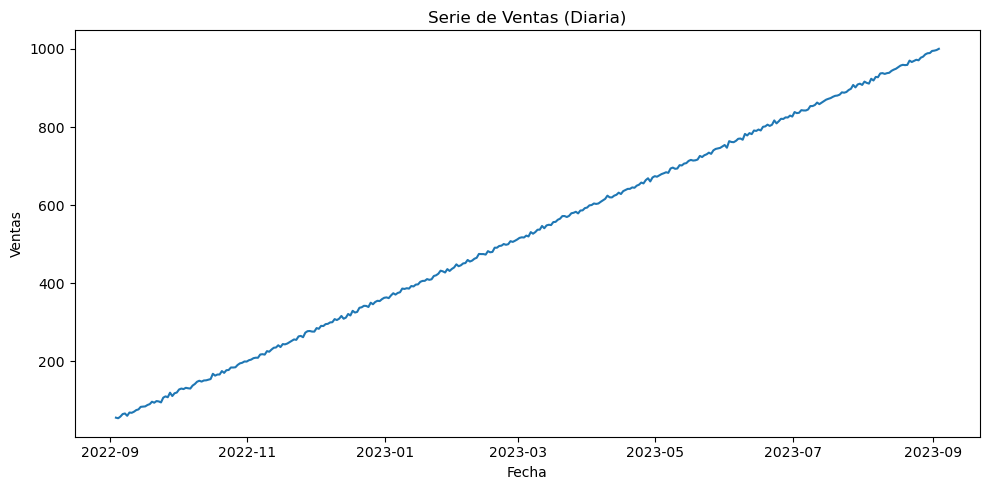

In [4]:
# graficamos
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=ts.index, y=ts.values, ax=ax)
ax.set_title("Serie de Ventas (Diaria)")
ax.set_xlabel("Fecha"); ax.set_ylabel("Ventas")
plt.tight_layout(); plt.show()

In [5]:
# decomposición de la serie
from statsmodels.tsa.seasonal import seasonal_decompose

# periodo estacional 30 dias porque necesita mínimo 2 periodos completos
m = 30
# si las fluctuaciones estacionales son aproximadamente constantes: additive. si son proporcionales al nivel: multiplicative.
decomposition = seasonal_decompose(ts, model="additive", period=m, extrapolate_trend="freq")

# tendencia, estacionalidad, residuo
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

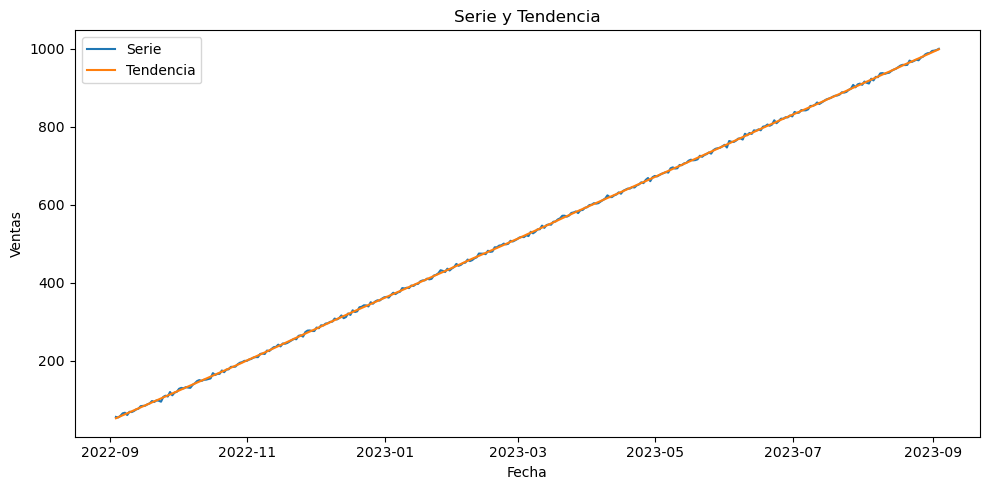

In [6]:
# Tendencia vs serie
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=ts.index, y=ts.values, ax=ax, label="Serie")
sns.lineplot(x=trend.index, y=trend.values, ax=ax, label="Tendencia")
ax.set_title("Serie y Tendencia"); ax.set_xlabel("Fecha"); ax.set_ylabel("Ventas")
plt.tight_layout(); plt.show()

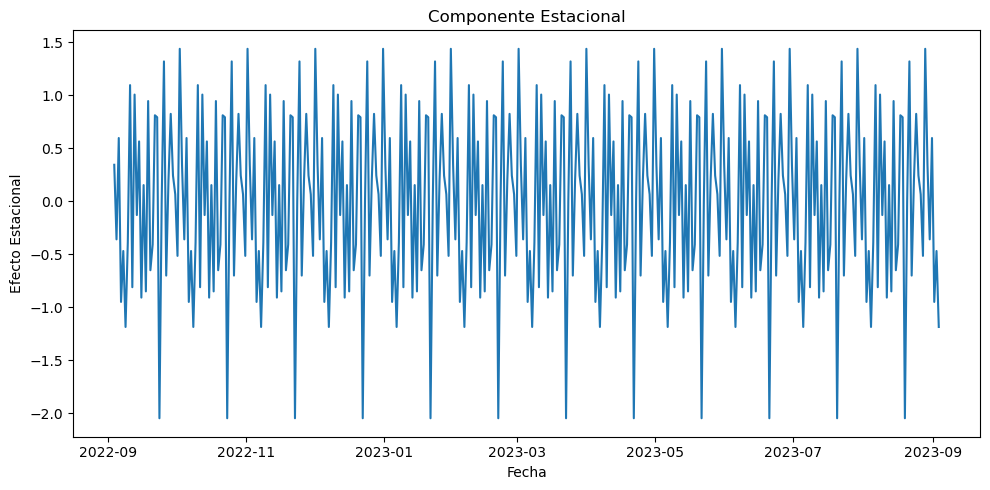

In [7]:
# Estacionalidad
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=seasonal.index, y=seasonal.values, ax=ax)
ax.set_title("Componente Estacional"); ax.set_xlabel("Fecha"); ax.set_ylabel("Efecto Estacional")
plt.tight_layout(); plt.show()

In [8]:
# prueba de dickey fuller 
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries.dropna(), autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Estadístico de prueba", "p-valor", "#Lags usados", "#Observaciones usadas"]
    )
    for key, value in dftest[4].items():
        dfoutput[f"Valor crítico ({key})"] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Estadístico de prueba      0.545414
p-valor                    0.986190
#Lags usados              13.000000
#Observaciones usadas    352.000000
Valor crítico (1%)        -3.449065
Valor crítico (5%)        -2.869786
Valor crítico (10%)       -2.571163
dtype: float64

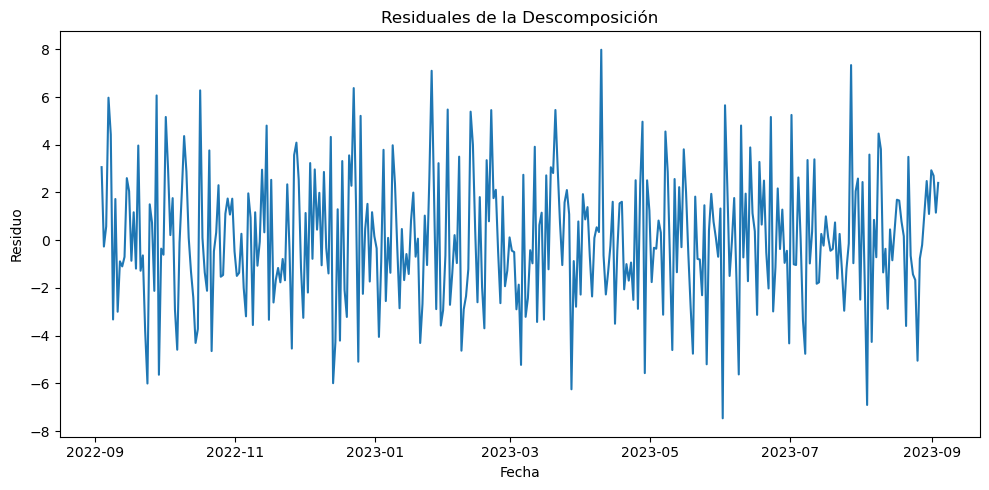

In [9]:
# residuales
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=residual.index, y=residual.values, ax=ax)
ax.set_title("Residuales de la Descomposición"); ax.set_xlabel("Fecha"); ax.set_ylabel("Residuo")
plt.tight_layout(); plt.show()

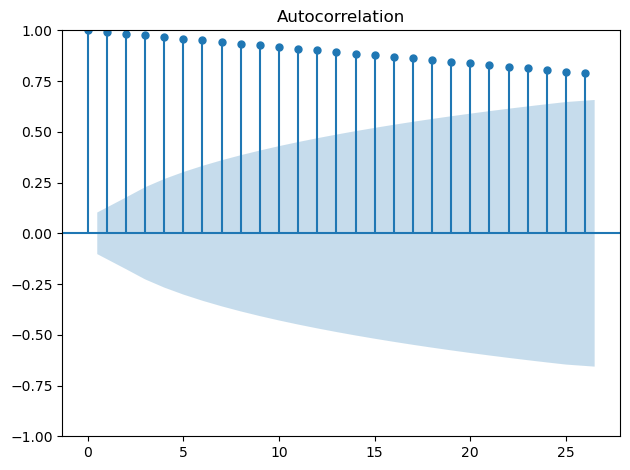

In [10]:
# Análisis de la autocorrelación ACF
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts.dropna())
plt.tight_layout()
plt.show()

Resultados de la prueba de Dickey-Fuller:
Estadístico de prueba   -9.430263e+00
p-valor                  5.212954e-16
#Lags usados             1.200000e+01
#Observaciones usadas    3.520000e+02
Valor crítico (1%)      -3.449065e+00
Valor crítico (5%)      -2.869786e+00
Valor crítico (10%)     -2.571163e+00
dtype: float64


<Figure size 1000x500 with 0 Axes>

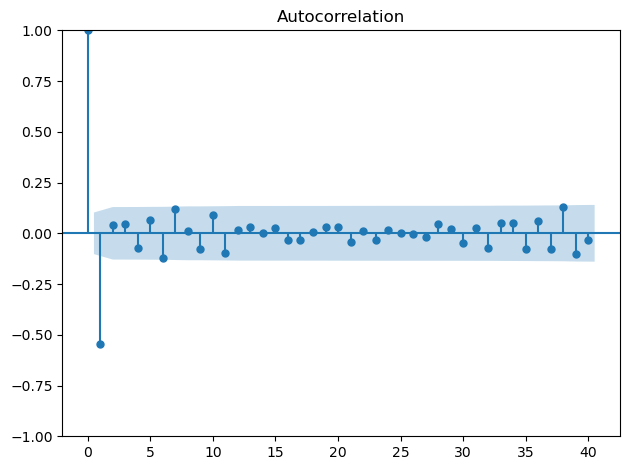

In [11]:
# ACF sobre la serie diferenciada (estacionaria)
# para detectar patrones verdaderos
ts_stationary = ts.diff().dropna()
print(test_stationarity(ts_stationary))

from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize=(10, 5))
plot_acf(ts_stationary, lags=40)
plt.tight_layout(); plt.show()

Por esta gráfica podemos ver que existe una relevancia dentro del primer día de ventas so, creo que 30 dias no sirve.

In [13]:
import warnings
warnings.filterwarnings('ignore')

# Entrenamiento del modelo DIFERENCIADO (ARIMA)
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

from pmdarima import auto_arima
model_diff = auto_arima(ts_stationary, seasonal = True, trace = True, m = 30)
model_diff.summary()

Resultados de la prueba de Dickey-Fuller:
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=1845.253, Time=3.63 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=1971.739, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[30] intercept   : AIC=1843.274, Time=2.52 sec
 ARIMA(2,0,2)(0,0,0)[30] intercept   : AIC=1843.049, Time=0.24 sec
 ARIMA(2,0,2)(1,0,0)[30] intercept   : AIC=1843.222, Time=1.97 sec
 ARIMA(1,0,2)(0,0,0)[30] intercept   : AIC=1843.587, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=1841.533, Time=0.19 sec
 ARIMA(2,0,1)(1,0,0)[30] intercept   : AIC=1841.441, Time=2.29 sec
 ARIMA(2,0,1)(2,0,0)[30] intercept   : AIC=1843.530, Time=11.13 sec
 ARIMA(2,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(2,0,1)(0,0,1)[30] intercept   : AIC=1841.425, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 30)   Log Likelihood                -914.720
Date:                            Thu, 14 Aug 2025   AIC                           1839.439
Time:                                    21:01:01   BIC                           1858.939
Sample:                                09-04-2022   HQIC                          1847.188
                                     - 09-03-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8192      0.134     20.986      0.000       2.556       3.083
ar.L1         -0.0850      0.052     -1.641      0.101      -0.187       0.016
ma.L1         -0.9435      0.020    -47.190      0.000      -0.983      -0.904
ma.S.L30      -0.0806      0.061     -1.323      0.186      -0.200       0.039
sigma2         8.7304      0.683     12.788      0.000       7.392      10.068
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.99   Prob(JB):                         0.68
Heteroskedasticity (H):               0.92   Skew:                             0.07
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# Entrenamiento del modelo directo

test_stationarity(ts)
model = auto_arima(ts, seasonal = False, trace = True, m = 30)
model.summary()

Resultados de la prueba de Dickey-Fuller:
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.732 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Thu, 14 Aug 2025   AIC                           1839.552
Time:                        21:01:32   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# Predicción del modelo diferenciado
forecast_diff = model_diff.predict(30)
forecast_diff

2023-09-04 17:10:08.079328    2.046148
2023-09-05 17:10:08.079328    2.162500
2023-09-06 17:10:08.079328    2.827505
2023-09-07 17:10:08.079328    2.042483
2023-09-08 17:10:08.079328    2.743390
2023-09-09 17:10:08.079328    2.940539
2023-09-10 17:10:08.079328    2.700119
2023-09-11 17:10:08.079328    2.713957
2023-09-12 17:10:08.079328    2.406173
2023-09-13 17:10:08.079328    2.549262
2023-09-14 17:10:08.079328    2.623742
2023-09-15 17:10:08.079328    2.473212
2023-09-16 17:10:08.079328    2.492436
2023-09-17 17:10:08.079328    2.652892
2023-09-18 17:10:08.079328    2.882323
2023-09-19 17:10:08.079328    2.762238
2023-09-20 17:10:08.079328    1.895069
2023-09-21 17:10:08.079328    3.122267
2023-09-22 17:10:08.079328    2.592938
2023-09-23 17:10:08.079328    2.547498
2023-09-24 17:10:08.079328    2.915993
2023-09-25 17:10:08.079328    2.220297
2023-09-26 17:10:08.079328    2.657565
2023-09-27 17:10:08.079328    2.298701
2023-09-28 17:10:08.079328    2.585472
2023-09-29 17:10:08.07932

In [16]:
# Predicción del modelo no diferenciado
forecast = model.predict(30)
forecast

2023-09-04 17:10:08.079328    1002.158118
2023-09-05 17:10:08.079328    1004.831639
2023-09-06 17:10:08.079328    1007.423258
2023-09-07 17:10:08.079328    1010.021597
2023-09-08 17:10:08.079328    1012.619384
2023-09-09 17:10:08.079328    1015.217217
2023-09-10 17:10:08.079328    1017.815046
2023-09-11 17:10:08.079328    1020.412876
2023-09-12 17:10:08.079328    1023.010705
2023-09-13 17:10:08.079328    1025.608534
2023-09-14 17:10:08.079328    1028.206364
2023-09-15 17:10:08.079328    1030.804193
2023-09-16 17:10:08.079328    1033.402023
2023-09-17 17:10:08.079328    1035.999852
2023-09-18 17:10:08.079328    1038.597681
2023-09-19 17:10:08.079328    1041.195511
2023-09-20 17:10:08.079328    1043.793340
2023-09-21 17:10:08.079328    1046.391170
2023-09-22 17:10:08.079328    1048.988999
2023-09-23 17:10:08.079328    1051.586828
2023-09-24 17:10:08.079328    1054.184658
2023-09-25 17:10:08.079328    1056.782487
2023-09-26 17:10:08.079328    1059.380317
2023-09-27 17:10:08.079328    1061

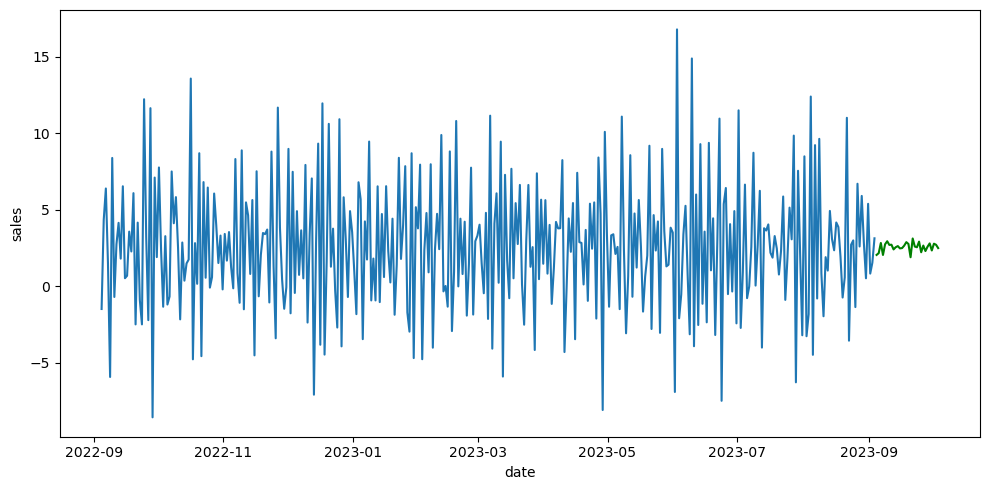

In [17]:
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast_diff, c = "green")
plt.tight_layout()
plt.show()

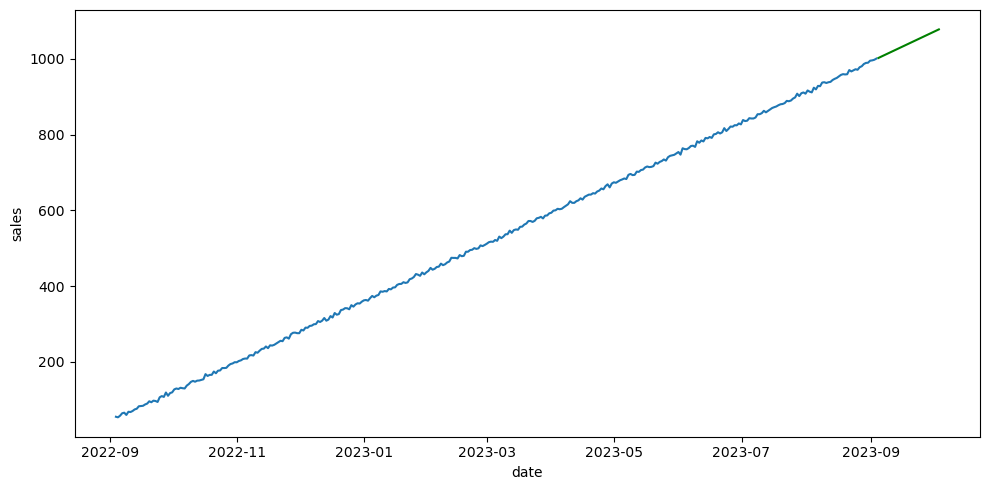

In [18]:
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = ts)
sns.lineplot(data = forecast, c = "green")
plt.tight_layout()
plt.show()

In [19]:
# creo que no sirvió :)

In [20]:
# guardar el modelo mejor con pickle en lugar de con joblib
import pickle
pickle.dump(model, open('series_tiempo_30dias.pkl', 'wb'))

## Conclusiones
(no entiendo honestamente porque salieron coeficientes tan cercanos, pero quiza es pedo mio)
* Intercepto (2.82): indica un nivel base de crecimiento constante en las ventas
* MA.L1 (-0.94): muestra fuerte corrección de errores pasados
* AR.L1 (-0.085): efecto autorregresivo débil
* MA.S.L30 (-0.081): No significativo (p = 0.186), componente estacional mensual débil

El modelo sugiere que las ventas dependen principalmente de los errores del último día, y que no hay un patrón estacional fuerte a 30 días. Los residuos se comportan como ruido aleatorio, lo cual es buena señal. Sin embargo, se podría simplificar el modelo quitando los términos no significativos y verificar si el AIC mejora.


